# LSTM Prediction

In [1]:
## 필요한 모듈 호출 ##
try:
    %matplotlib inline
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    import pandas as pd
    from pandas.tseries.offsets import DateOffset
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import load_model
    import pickle
except ModuleNotFoundError:
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install scikit-learn
    !pip install keras
    %matplotlib inline
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    import pandas as pd
    from pandas.tseries.offsets import DateOffset
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import load_model
    import pickle

<AxesSubplot:>

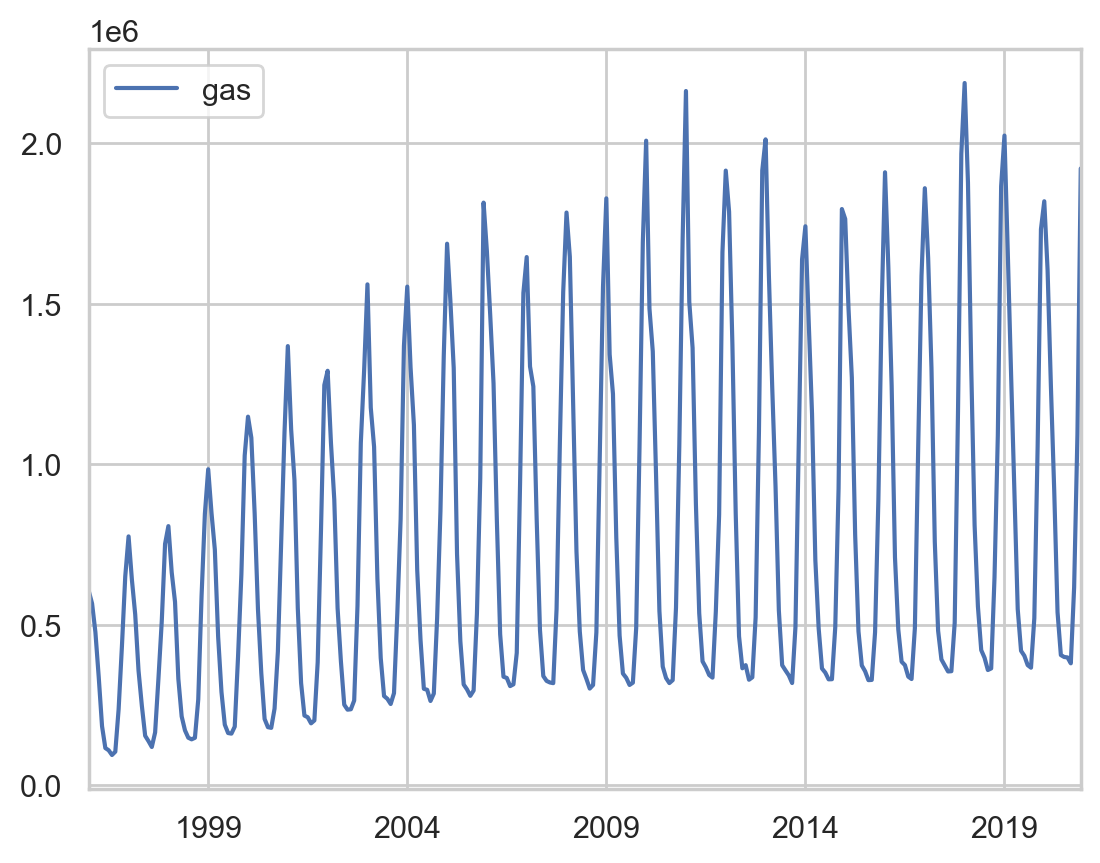

In [2]:
## 민수용 데이터 불러오기 ##
#제공된 데이터 파일(월별공급량및비중) 사용 / 본 파일과 데이터파일이 같은 폴더에 위치한 후 실행가능
data = pd.read_csv('월별공급량및비중.csv')
civil = data["도시가스(톤)_민수용"]
civil.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
civil = civil.to_frame()
civil.columns=['gas']
civil.index = pd.DatetimeIndex(civil.index.values,
                               freq=civil.index.inferred_freq)
civil.plot()

<AxesSubplot:>

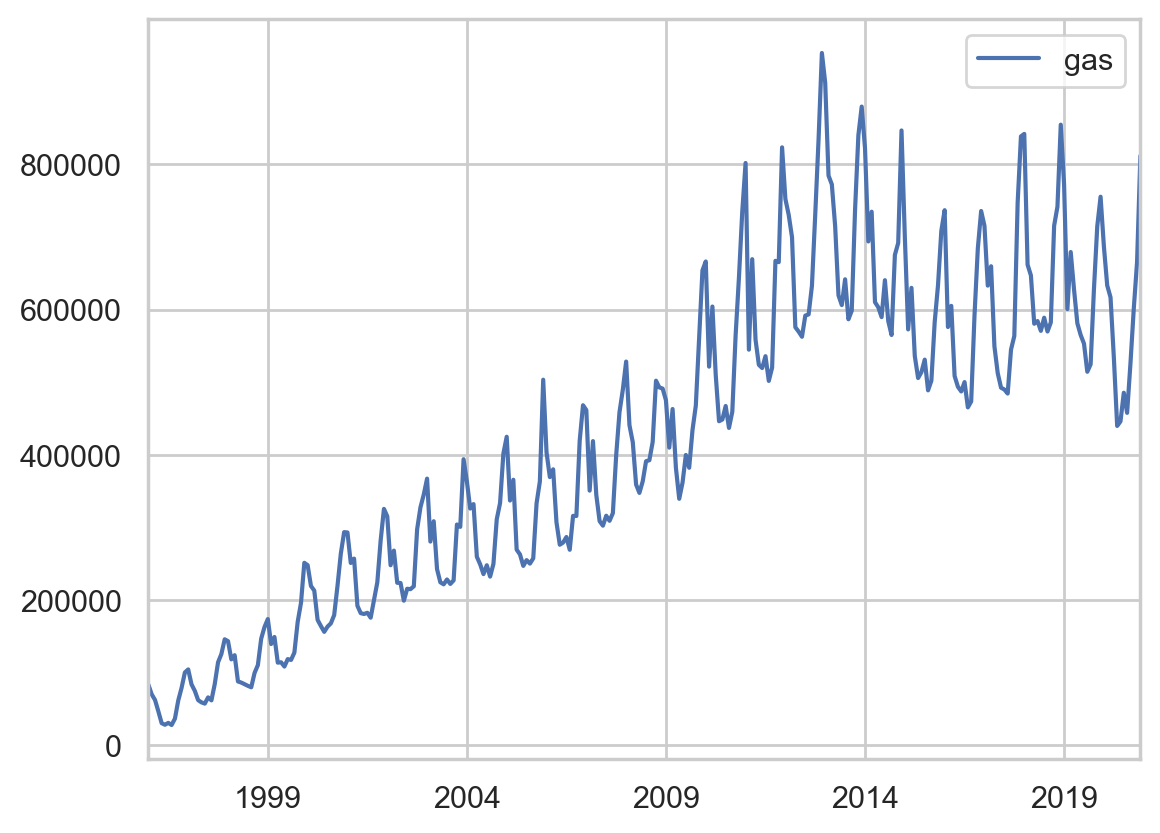

In [3]:
## 산업용 데이터 불러오기 ##
ind = data["도시가스(톤)_산업용"]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = ind.to_frame()
ind.columns=['gas']
ind.index = pd.DatetimeIndex(ind.index.values,
                               freq=ind.index.inferred_freq)
ind.plot()

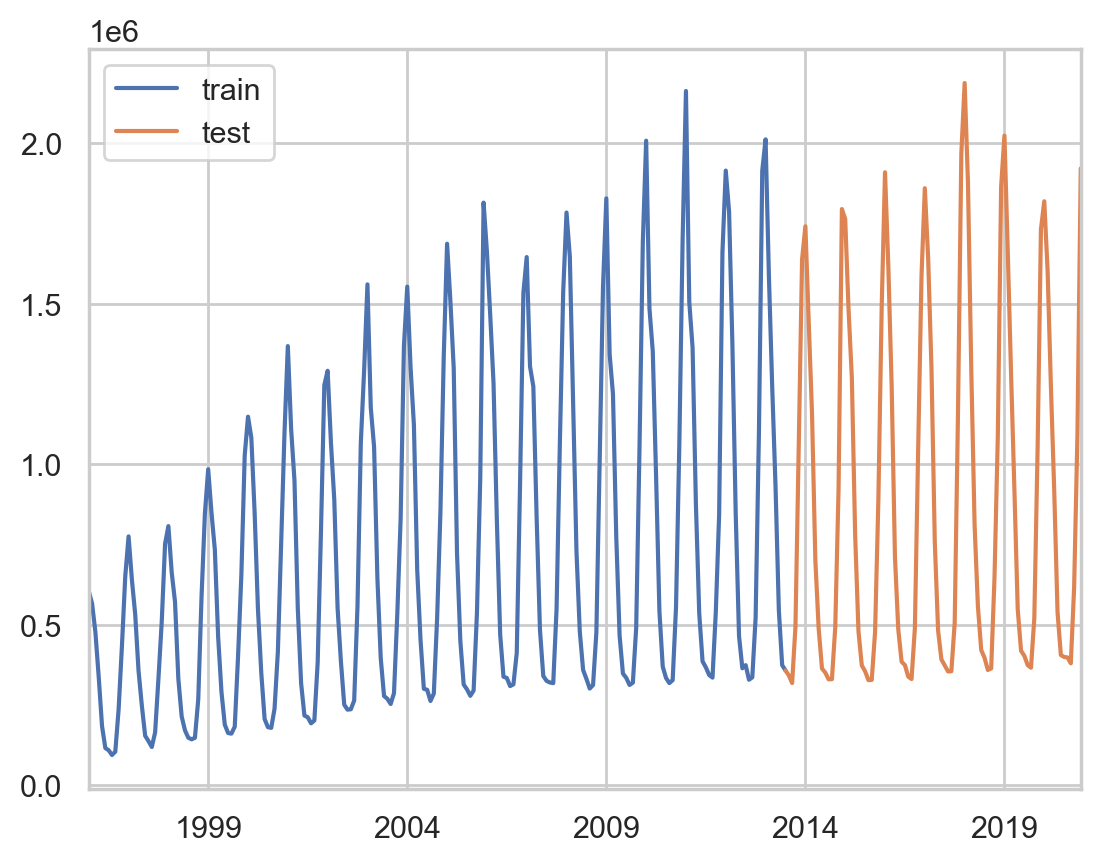

In [4]:
## train-test 데이터 분리 (민수용: 변수 앞에 c) ##
split_date = pd.Timestamp('07-01-2013') #월-일-년 / rate : 0.3
ctrain = civil.loc[:split_date]
ctest = civil.loc[split_date:]

ax = ctrain.plot()
ctest.plot(ax=ax)
plt.legend(['train', 'test'])

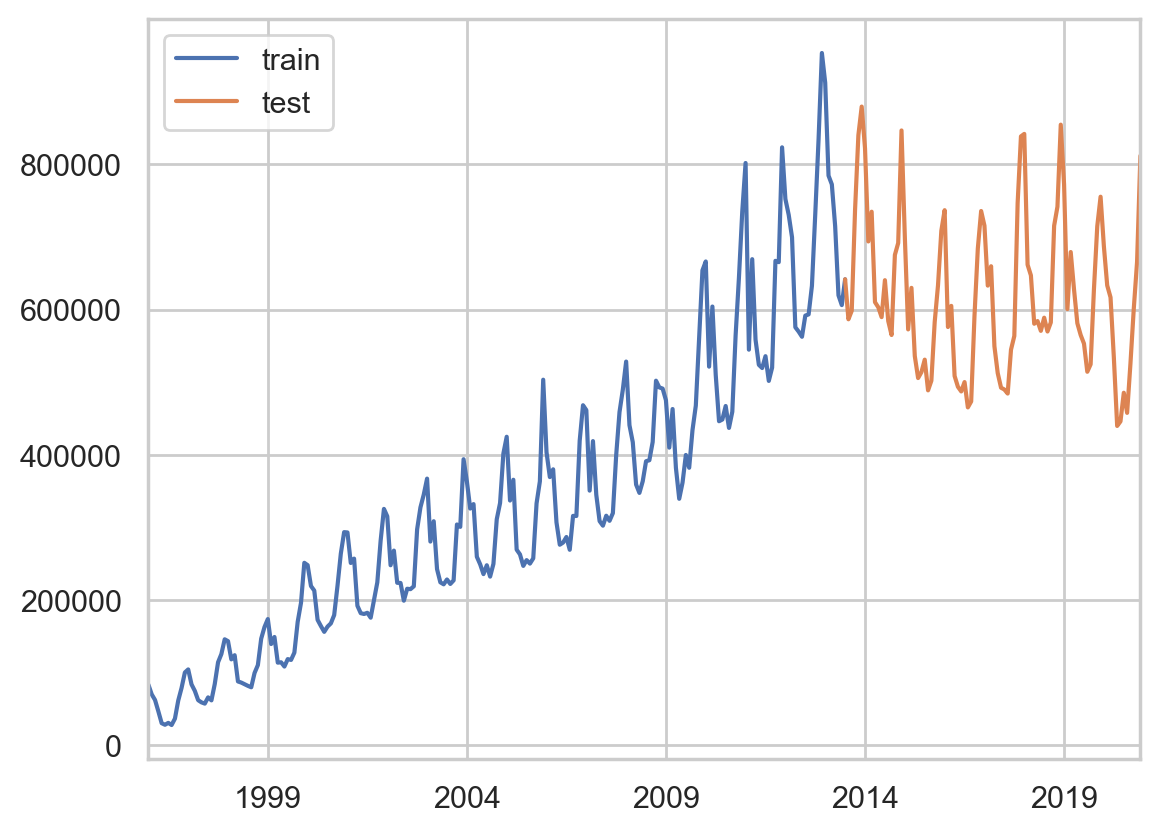

In [5]:
## train-test 데이터 분리 (산업용: 변수 앞에 i) ##
split_date = pd.Timestamp('07-01-2013') #월-일-년 / rate : 0.3
itrain = ind.loc[:split_date]
itest = ind.loc[split_date:]

ax = itrain.plot()
itest.plot(ax=ax)
plt.legend(['train', 'test'])

In [6]:
## 민수용 데이터 전처리 ##
#Scaling
sc1 = MinMaxScaler()
train_sc = sc1.fit_transform(ctrain)
test_sc = sc1.transform(ctest)

#DataFrame으로 바꿈
ctrain_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=ctrain.index)
ctest_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=ctest.index)

#12번 shift (1년의 주기성을 가지므로)
for s in range(1, 13):
    ctrain_sc_df['shift_{}'.format(s)] = ctrain_sc_df['Scaled'].shift(s)
    ctest_sc_df['shift_{}'.format(s)] = ctest_sc_df['Scaled'].shift(s)
    
#X, Y 분리 (기존 Scaled열을 Y로 하고 이를 제외한 나머지 shift한 열들을 X로 함)
X_train = ctrain_sc_df.dropna().drop('Scaled', axis=1)
Y_train = ctrain_sc_df.dropna()[['Scaled']]
X_test = ctest_sc_df.dropna().drop('Scaled', axis=1)
Y_test = ctest_sc_df.dropna()[['Scaled']]

#DataFrame에서 NumpyArray로 변경
X_train = X_train.values
X_test = X_test.values
cY_train = Y_train.values
cY_test = Y_test.values

#LSTM input형식에 맞게 reshape
cX_train_t = X_train.reshape(X_train.shape[0], 12, 1)
cX_test_t = X_test.reshape(X_test.shape[0], 12, 1)
print("CIVIL 최종 DATA")
print(cX_train_t.shape)
print(cX_train_t)
print(cY_train)

CIVIL 최종 DATA
(199, 12, 1)
[[[0.26913139]
  [0.16427444]
  [0.06892207]
  ...
  [0.18511893]
  [0.2280687 ]
  [0.24702465]]

 [[0.32924143]
  [0.26913139]
  [0.16427444]
  ...
  [0.1175476 ]
  [0.18511893]
  [0.2280687 ]]

 [[0.26403065]
  [0.32924143]
  [0.26913139]
  ...
  [0.04342227]
  [0.1175476 ]
  [0.18511893]]

 ...

 [[0.40450327]
  [0.55428509]
  [0.72175819]
  ...
  [0.13530805]
  [0.13063241]
  [0.17888072]]

 [[0.2177028 ]
  [0.40450327]
  [0.55428509]
  ...
  [0.1133435 ]
  [0.13530805]
  [0.13063241]]

 [[0.13523551]
  [0.2177028 ]
  [0.40450327]
  ...
  [0.11701175]
  [0.1133435 ]
  [0.13530805]]]
[[0.32924143]
 [0.26403065]
 [0.2116798 ]
 [0.12707007]
 [0.074283  ]
 [0.02895962]
 [0.0209475 ]
 [0.01208033]
 [0.03397379]
 [0.11493412]
 [0.20119106]
 [0.31797164]
 [0.34470323]
 [0.27504363]
 [0.23059416]
 [0.11468361]
 [0.05819152]
 [0.03710378]
 [0.02603904]
 [0.02360789]
 [0.02591089]
 [0.08361637]
 [0.23934477]
 [0.36323021]
 [0.43030099]
 [0.3642579 ]
 [0.30932743]
 

In [7]:
## 산업용 데이터 전처리 ##
#Scaling
sc2 = MinMaxScaler()
train_sc = sc2.fit_transform(itrain)
test_sc = sc2.transform(itest)

#DataFrame으로 바꿈
itrain_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=itrain.index)
itest_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=itest.index)

#12번 shift (1년의 주기성을 가지므로)
for s in range(1, 13):
    itrain_sc_df['shift_{}'.format(s)] = itrain_sc_df['Scaled'].shift(s)
    itest_sc_df['shift_{}'.format(s)] = itest_sc_df['Scaled'].shift(s)
    
#X, Y 분리 (기존 Scaled열을 Y로 하고 이를 제외한 나머지 shift한 열들을 X로 함)
X_train = itrain_sc_df.dropna().drop('Scaled', axis=1)
Y_train = itrain_sc_df.dropna()[['Scaled']]
X_test = itest_sc_df.dropna().drop('Scaled', axis=1)
Y_test = itest_sc_df.dropna()[['Scaled']]

#DataFrame에서 NumpyArray로 변경
X_train = X_train.values
X_test = X_test.values
iY_train = Y_train.values
iY_test = Y_test.values

#LSTM input형식에 맞게 reshape
iX_train_t = X_train.reshape(X_train.shape[0], 12, 1)
iX_test_t = X_test.reshape(X_test.shape[0], 12, 1)
print("IND 최종 DATA")
print(iX_train_t.shape)
print(iX_train_t)
print(iY_train)

IND 최종 DATA
(199, 12, 1)
[[[0.07820584]
  [0.05520819]
  [0.03649491]
  ...
  [0.03724932]
  [0.04565268]
  [0.06011619]]

 [[0.08270529]
  [0.07820584]
  [0.05520819]
  ...
  [0.02038639]
  [0.03724932]
  [0.04565268]]

 [[0.06048367]
  [0.08270529]
  [0.07820584]
  ...
  [0.00272474]
  [0.02038639]
  [0.03724932]]

 ...

 [[0.74231781]
  [0.80448215]
  [0.81757194]
  ...
  [0.60923019]
  [0.57774379]
  [0.58537545]]

 [[0.63940015]
  [0.74231781]
  [0.80448215]
  ...
  [0.61102435]
  [0.60923019]
  [0.57774379]]

 [[0.62485449]
  [0.63940015]
  [0.74231781]
  ...
  [0.65357724]
  [0.61102435]
  [0.60923019]]]
[[0.08270529]
 [0.06048367]
 [0.05074225]
 [0.03695534]
 [0.03370856]
 [0.03184739]
 [0.04113378]
 [0.03668945]
 [0.06091924]
 [0.09338269]
 [0.10562188]
 [0.12754411]
 [0.12477289]
 [0.09769191]
 [0.10387635]
 [0.06482747]
 [0.06312843]
 [0.06060688]
 [0.05826475]
 [0.05616039]
 [0.07742981]
 [0.0891621 ]
 [0.12848118]
 [0.14584452]
 [0.15766868]
 [0.1205015 ]
 [0.13100273]
 [0

In [8]:
## LSTM 모델 불러오기 ##
#모델파일이 본 파일과 같은 폴더에 위치한 후 실행가능
cmodel = load_model('lstm_civil.h5', compile = True)
imodel = load_model('lstm_ind.h5', compile = True)
cmodel.summary(), imodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 300)           362400    
                                                                 
 dropout (Dropout)           (None, 12, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)              

(None, None)

3/3 [==============================] - 0s 12ms/step


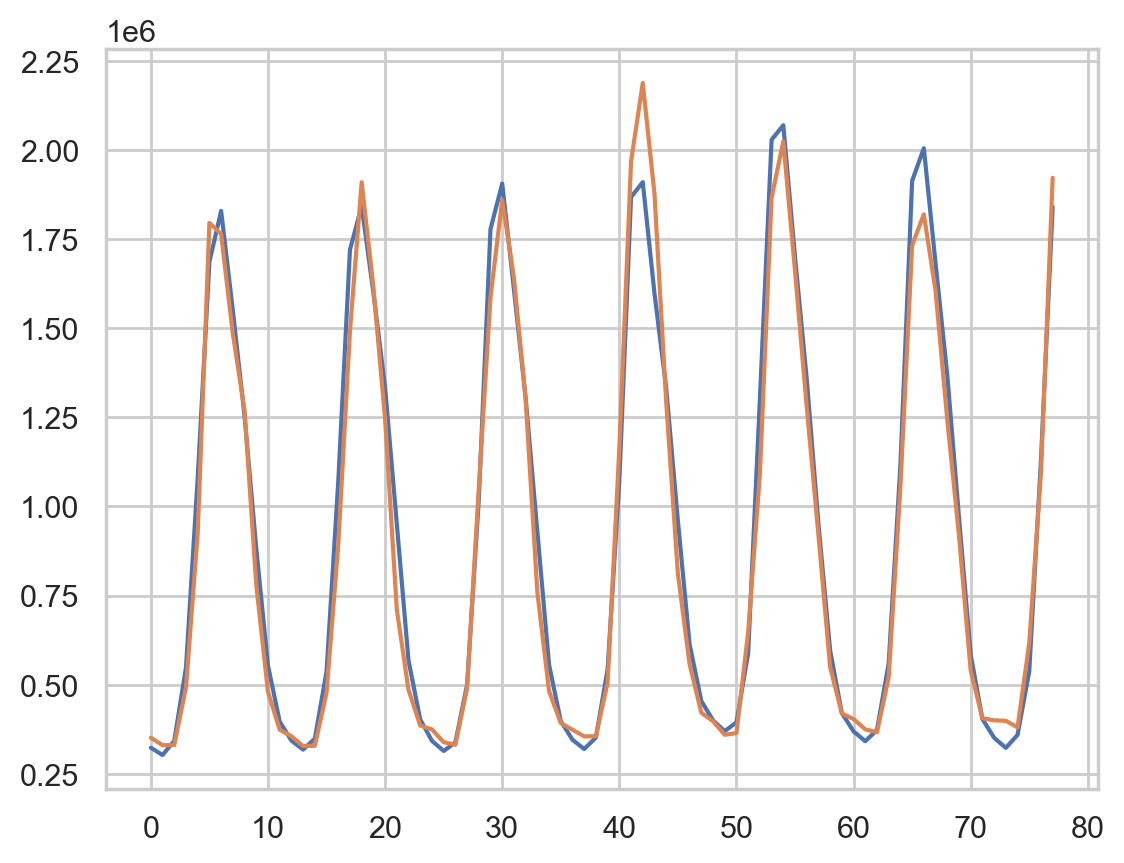

In [9]:
## 모델 Evaluation - 민수용 y값 예측값과 기존값(y test값) 비교 ##
cY_pred = cmodel.predict(cX_test_t)
cy_pred = sc1.inverse_transform(cY_pred)
cy_test = sc1.inverse_transform(cY_test)
plt.figure()
plt.plot(cy_pred)
plt.plot(cy_test)

3/3 [==============================] - 0s 11ms/step


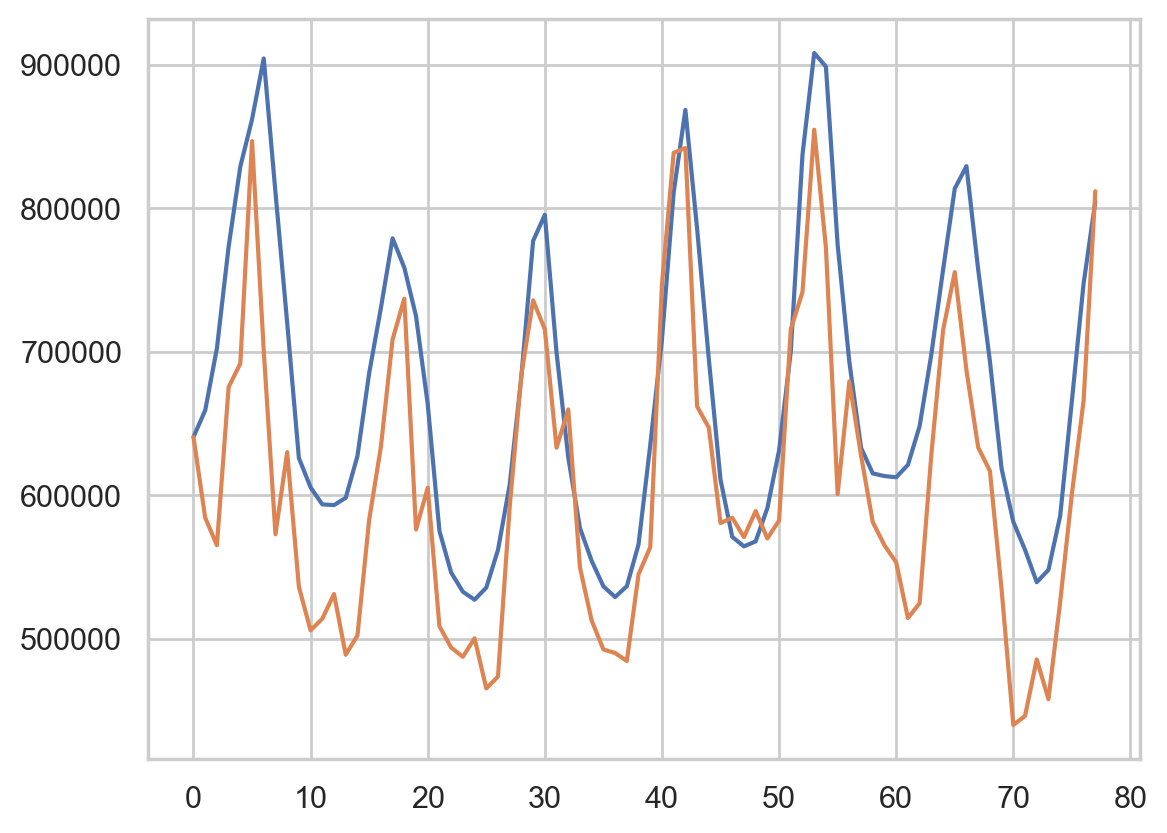

In [10]:
## 모델 Evaluation - 산업용 y값 예측값과 기존값(y test값) 비교 ##
iY_pred = imodel.predict(iX_test_t)
iy_pred = sc2.inverse_transform(iY_pred)
iy_test = sc2.inverse_transform(iY_test)
plt.figure()
plt.plot(iy_pred)
plt.plot(iy_test)

In [11]:
## 민수용 - 미래를 예측할 DataFrame 생성 및 예측의 첫 X값(기존 데이터의 마지막 값) 넣어주기 ##
cpred_date = [ctest_sc_df.index[-1] + DateOffset(months=x) for x in range(0,169)]
cpred_date = pd.DataFrame(index=cpred_date[1:], columns=ctest_sc_df.columns)
cpred_date.iloc[0,1:] = ctest_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1)
print(cpred_date)

cnew_X = np.reshape(cpred_date.iloc[0,1:].values, (-1, 12, 1))
cnew_X = np.asarray(cnew_X).astype('float32')
print('CIVIL new_X: ', cnew_X)

           Scaled   shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
2021-01-01    NaN  0.883412  0.483141  0.252423  0.138073  0.146984  0.147601   
2021-02-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021-03-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021-04-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021-05-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
2034-08-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-09-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-10-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-11-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2034-12-01    NaN       NaN       NaN       NaN       NaN       NaN       NaN   

             shift_7   shif

In [12]:
## 산업용 - 미래를 예측할 DataFrame 생성 및 예측의 첫 X값(기존 DataFrame의 마지막 값) 넣어주기 ##
ipred_date = [itest_sc_df.index[-1] + DateOffset(months=x) for x in range(0,169)]
ipred_date = pd.DataFrame(index=ipred_date[1:], columns=itest_sc_df.columns)
ipred_date.iloc[0,1:] = itest_sc_df['2020-12-01':].shift(axis=1).drop('Scaled', axis=1)
print(ipred_date)

inew_X = np.reshape(ipred_date.iloc[0,1:].values, (-1, 12, 1))
inew_X = np.asarray(inew_X).astype('float32')
print('IND new_X: ', inew_X)

           Scaled  shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
2021-01-01    NaN  0.84708  0.689252  0.618987  0.537632  0.464516  0.494435   
2021-02-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2021-03-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2021-04-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2021-05-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
...           ...      ...       ...       ...       ...       ...       ...   
2034-08-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-09-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-10-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-11-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2034-12-01    NaN      NaN       NaN       NaN       NaN       NaN       NaN   

             shift_7   shift_8   shift_

In [13]:
## 첫 X값으로 첫 Y값(2021년 1월) 예측 후 DataFrame에 넣어주기 ## 
cnew_Y_pred = cmodel.predict(cnew_X)
cpred_date.iloc[0,0] = cnew_Y_pred[0][0]

inew_Y_pred = imodel.predict(inew_X)
ipred_date.iloc[0,0] = inew_Y_pred[0][0]

print('CIVIL : ', cpred_date)
print('IND : ', ipred_date)

1/1 [==============================] - 0s 24ms/step
CIVIL :                Scaled   shift_1   shift_2   shift_3   shift_4   shift_5  \
2021-01-01  0.886646  0.883412  0.483141  0.252423  0.138073  0.146984   
2021-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2021-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2021-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2021-05-01       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2034-08-01       NaN       NaN       NaN       NaN       NaN       NaN   
2034-09-01       NaN       NaN       NaN       NaN       NaN       NaN   
2034-10-01       NaN       NaN       NaN       NaN       NaN       NaN   
2034-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2034-12-01       NaN       NaN       NaN       NaN       NaN       NaN   

             shift_6   shift_7   shift_8   shift_9

In [14]:
## 이를 반복하여 2034년 12월까지 예측값 생성하기 ##
for i in range(1, 168):
    cpred_date.iloc[i, 1:] = cpred_date.iloc[i-1][:-1].values
    cnew_X = np.reshape(cpred_date.iloc[i, 1:].values, (-1, 12, 1))
    cnew_X = np.asarray(cnew_X).astype('float32')
    cnew_Y_pred = cmodel.predict(cnew_X)
    cpred_date.iloc[i,0] = cnew_Y_pred[0][0]

for i in range(1, 168):
    ipred_date.iloc[i, 1:] = ipred_date.iloc[i-1][:-1].values
    inew_X = np.reshape(ipred_date.iloc[i, 1:].values, (-1, 12, 1))
    inew_X = np.asarray(inew_X).astype('float32')
    inew_Y_pred = imodel.predict(inew_X)
    ipred_date.iloc[i,0] = inew_Y_pred[0][0]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


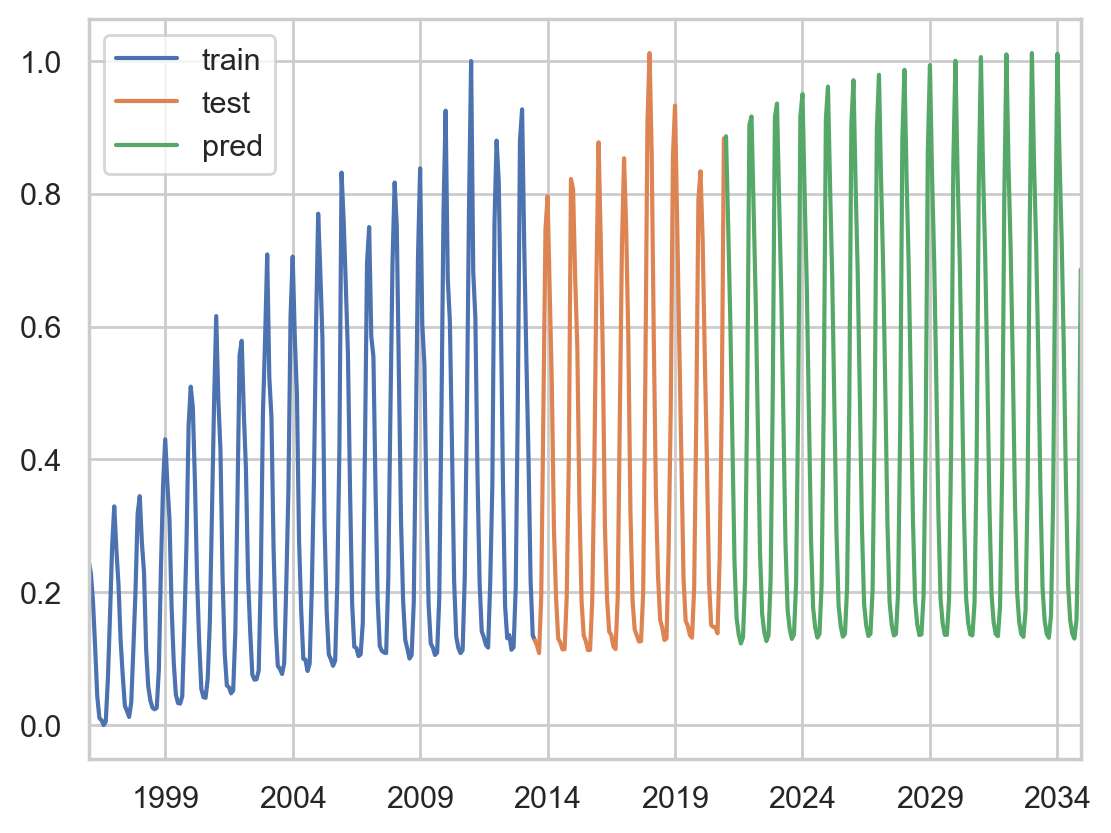

In [15]:
## 민수용 기존 train, test 값과 예측한 값 그래프로 확인 ##
ctrain_sc_df['Scaled'].plot()
ctest_sc_df['Scaled'].plot()
cpred_date['Scaled'].plot()
plt.legend(['train', 'test','pred'])

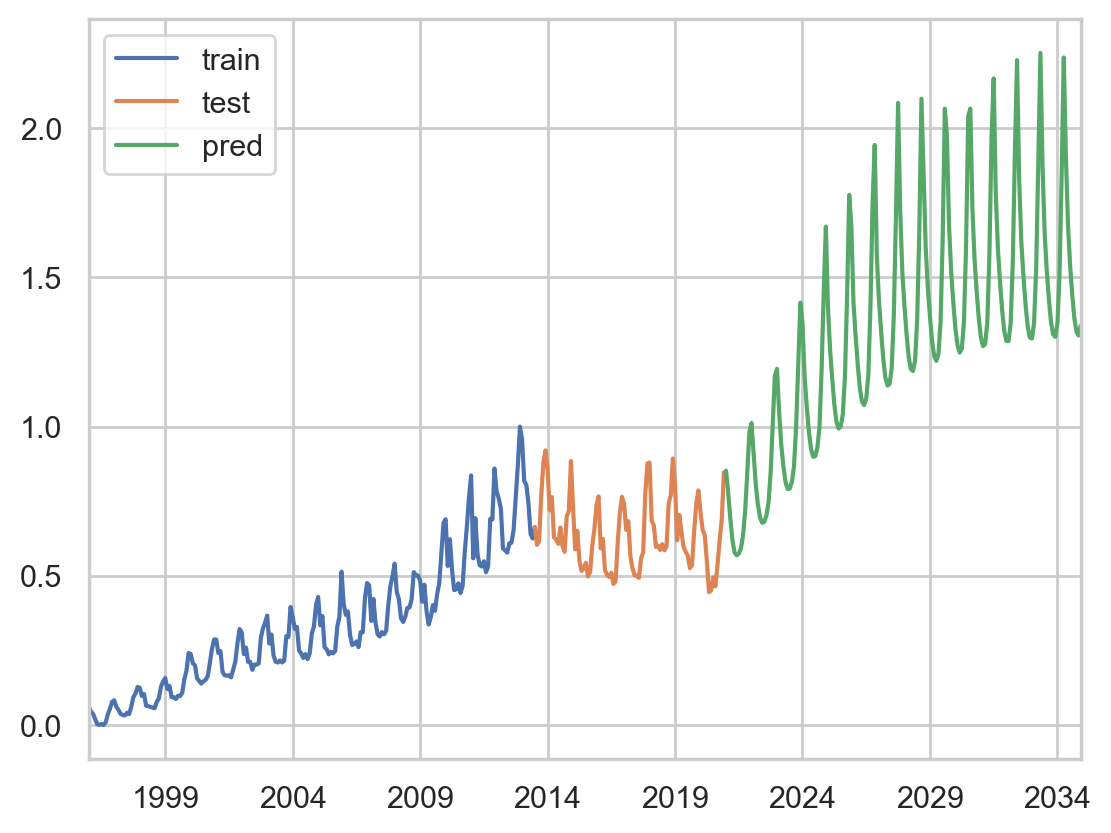

In [16]:
## 산업용 기존 train, test 값과 예측한 값 그래프로 확인 ##
itrain_sc_df['Scaled'].plot()
itest_sc_df['Scaled'].plot()
ipred_date['Scaled'].plot()
plt.legend(['train', 'test','pred'])

In [17]:
## 민수용 - 최종 예측한 값 scaling 되돌리기 ##
tmp = np.reshape(cpred_date['Scaled'].values, (1, -1))
pred = sc1.inverse_transform(tmp)
cpred_date['final'] = pred.flatten()
cpred_date

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,final
2021-01-01,0.886646,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,0.833947,1.928091e+06
2021-02-01,0.754266,0.886646,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,0.730238,1.654362e+06
2021-03-01,0.611337,0.754266,0.886646,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,0.555391,1.358824e+06
2021-04-01,0.426034,0.611337,0.754266,0.886646,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,0.398246,9.756632e+05
2021-05-01,0.244491,0.426034,0.611337,0.754266,0.886646,0.883412,0.483141,0.252423,0.138073,0.146984,0.147601,0.150538,0.215105,6.002795e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,0.137399,0.158154,0.213982,0.369958,0.569884,0.73164,0.853528,1.010944,0.724751,0.340409,0.16522,0.131404,0.137123,3.788417e+05
2034-09-01,0.130122,0.137399,0.158154,0.213982,0.369958,0.569884,0.73164,0.853528,1.010944,0.724751,0.340409,0.16522,0.131404,3.637947e+05
2034-10-01,0.158828,0.130122,0.137399,0.158154,0.213982,0.369958,0.569884,0.73164,0.853528,1.010944,0.724751,0.340409,0.16522,4.231507e+05
2034-11-01,0.317125,0.158828,0.130122,0.137399,0.158154,0.213982,0.369958,0.569884,0.73164,0.853528,1.010944,0.724751,0.340409,7.504684e+05


In [18]:
## 산업용 - 최종 예측한 값 scaling 되돌리기 ##
tmp = np.reshape(ipred_date['Scaled'].values, (1, -1))
pred = sc2.inverse_transform(tmp)
ipred_date['final'] = pred.flatten()
ipred_date

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,final
2021-01-01,0.85242,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,0.712147,8.168680e+05
2021-02-01,0.780331,0.85242,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,0.65412,7.501700e+05
2021-03-01,0.693523,0.780331,0.85242,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,0.636397,6.698526e+05
2021-04-01,0.621011,0.693523,0.780331,0.85242,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,0.547036,6.027634e+05
2021-05-01,0.578616,0.621011,0.693523,0.780331,0.85242,0.84708,0.689252,0.618987,0.537632,0.464516,0.494435,0.451833,0.445039,5.635385e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034-08-01,1.440889,1.538536,1.673218,1.906551,2.237228,1.841467,1.506336,1.342756,1.300983,1.30926,1.349639,1.427046,1.522182,1.361335e+06
2034-09-01,1.361822,1.440889,1.538536,1.673218,1.906551,2.237228,1.841467,1.506336,1.342756,1.300983,1.30926,1.349639,1.427046,1.288179e+06
2034-10-01,1.317753,1.361822,1.440889,1.538536,1.673218,1.906551,2.237228,1.841467,1.506336,1.342756,1.300983,1.30926,1.349639,1.247406e+06
2034-11-01,1.305282,1.317753,1.361822,1.440889,1.538536,1.673218,1.906551,2.237228,1.841467,1.506336,1.342756,1.300983,1.30926,1.235868e+06


In [19]:
## 결과 제출파일 형식에 맞춰 바꿔주기 ##
fin_lstm = pd.DataFrame()
fin_lstm['YEAR'] = cpred_date.index.year
fin_lstm['MONTH'] = cpred_date.index.month
fin_lstm['CIVIL'] = cpred_date['final'].values
fin_lstm['IND'] = ipred_date['final'].values
fin_lstm

,YEAR,MONTH,CIVIL,IND
0,2021,1,1.928091e+06,8.168680e+05
1,2021,2,1.654362e+06,7.501700e+05
2,2021,3,1.358824e+06,6.698526e+05
3,2021,4,9.756632e+05,6.027634e+05
4,2021,5,6.002795e+05,5.635385e+05
...,...,...,...,...
163,2034,8,3.788417e+05,1.361335e+06
164,2034,9,3.637947e+05,1.288179e+06
165,2034,10,4.231507e+05,1.247406e+06
166,2034,11,7.504684e+05,1.235868e+06


# XGboost Prediction

In [20]:
## XGBOOST 모델 불러오기 ##
#모델파일이 본 파일과 같은 폴더에 위치한 후 실행가능
with open(file='xgb_civil.pkl', mode='rb') as f:
    creg = pickle.load(f)
with open(file='xgb_ind.pkl', mode='rb') as f:
    ireg = pickle.load(f)

In [21]:
civil = data[['YEAR', 'MONTH', "도시가스(톤)_민수용"]]
civil.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = data[['YEAR', 'MONTH', "도시가스(톤)_산업용"]]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")

In [22]:
## 1년 shift, 2년 shift한 열 추가 ##
def add_lags(df, tf):
    if tf == True: #민수용
        df['lag1'] = df['도시가스(톤)_민수용'].shift(12)
        df['lag2'] = df['도시가스(톤)_민수용'].shift(24)
    else: #산업용
        df['lag1'] = df['도시가스(톤)_산업용'].shift(12)
        df['lag2'] = df['도시가스(톤)_산업용'].shift(24)
    return df

civil = civil.sort_index()
ind = ind.sort_index()
civil = add_lags(civil, True)
ind = add_lags(ind, False)

In [23]:
## 민수용 - 미래 1년치 예측을 위한 DataFrame 생성 후 기존에 이어붙임 ##
future = pd.date_range('2021-01-01','2021-12-01', freq='MS')
future_civil = pd.DataFrame(index=future)
future_civil['MONTH'] = future.month
future_civil['isFuture'] = True  #예측할 기간은 True로 표시
civil['isFuture'] = False
civil_and_future = pd.concat([civil, future_civil])
civil_and_future = add_lags(civil_and_future, True)
print(civil_and_future)

              YEAR  MONTH  도시가스(톤)_민수용       lag1       lag2  isFuture
1996-01-01  1996.0      1     605519.0        NaN        NaN     False
1996-02-01  1996.0      2     566323.0        NaN        NaN     False
1996-03-01  1996.0      3     477514.0        NaN        NaN     False
1996-04-01  1996.0      4     337794.0        NaN        NaN     False
1996-05-01  1996.0      5     184522.0        NaN        NaN     False
...            ...    ...          ...        ...        ...       ...
2021-08-01     NaN      8          NaN   398661.0   374639.0      True
2021-09-01     NaN      9          NaN   380235.0   366621.0      True
2021-10-01     NaN     10          NaN   616682.0   520739.0      True
2021-11-01     NaN     11          NaN  1093747.0  1055013.0      True
2021-12-01     NaN     12          NaN  1921404.0  1732147.0      True

[312 rows x 6 columns]


In [24]:
## 산업용 - 미래 1년치 예측을 위한 DataFrame 생성 후 기존에 이어붙임 ##
future_ind = pd.DataFrame(index=future)
future_ind['MONTH'] = future.month
future_ind['isFuture'] = True  #예측할 기간은 True로 표시
ind['isFuture'] = False
ind_and_future = pd.concat([ind, future_ind])
ind_and_future = add_lags(ind_and_future, False)
print(ind_and_future)

              YEAR  MONTH  도시가스(톤)_산업용      lag1      lag2  isFuture
1996-01-01  1996.0      1      83809.0       NaN       NaN     False
1996-02-01  1996.0      2      70427.0       NaN       NaN     False
1996-03-01  1996.0      3      62652.0       NaN       NaN     False
1996-04-01  1996.0      4      47050.0       NaN       NaN     False
1996-05-01  1996.0      5      30709.0       NaN       NaN     False
...            ...    ...          ...       ...       ...       ...
2021-08-01     NaN      8          NaN  457970.0  514526.0      True
2021-09-01     NaN      9          NaN  525619.0  524795.0      True
2021-10-01     NaN     10          NaN  600890.0  628223.0      True
2021-11-01     NaN     11          NaN  665901.0  714870.0      True
2021-12-01     NaN     12          NaN  811928.0  755546.0      True

[312 rows x 6 columns]


In [25]:
## 미래 예측할 부분만 분리 및 예측 ##

FEATURES = ['MONTH', 'lag1','lag2']
#민수용
cfuture_w_features = civil_and_future.query('isFuture').copy()
cfuture_w_features['pred'] = creg.predict(cfuture_w_features[FEATURES])
print(cfuture_w_features)

#산업용
ifuture_w_features = ind_and_future.query('isFuture').copy()
ifuture_w_features['pred'] = ireg.predict(ifuture_w_features[FEATURES])
print(ifuture_w_features)

            YEAR  MONTH  도시가스(톤)_민수용       lag1       lag2  isFuture  \
2021-01-01   NaN      1          NaN  1819123.0  2023662.0      True   
2021-02-01   NaN      2          NaN  1604680.0  1660132.0      True   
2021-03-01   NaN      3          NaN  1243141.0  1279302.0      True   
2021-04-01   NaN      4          NaN   918206.0   920035.0      True   
2021-05-01   NaN      5          NaN   539517.0   548871.0      True   
2021-06-01   NaN      6          NaN   406010.0   419341.0      True   
2021-07-01   NaN      7          NaN   399937.0   403664.0      True   
2021-08-01   NaN      8          NaN   398661.0   374639.0      True   
2021-09-01   NaN      9          NaN   380235.0   366621.0      True   
2021-10-01   NaN     10          NaN   616682.0   520739.0      True   
2021-11-01   NaN     11          NaN  1093747.0  1055013.0      True   
2021-12-01   NaN     12          NaN  1921404.0  1732147.0      True   

                    pred  
2021-01-01  1.833040e+06  
2021-02-0

In [26]:
## 그 이후를 다시 예측하기 위해 예측한 1년치 값을 기존 값에 넣고 isFuture를 False로 바꿈 ##
#민수용
civil_and_future.loc[cfuture_w_features.index, '도시가스(톤)_민수용']=cfuture_w_features['pred']
civil_and_future['isFuture'] = False
print(civil_and_future)

#산업용
ind_and_future.loc[ifuture_w_features.index, '도시가스(톤)_산업용']=ifuture_w_features['pred']
ind_and_future['isFuture'] = False
print(ind_and_future)

              YEAR  MONTH   도시가스(톤)_민수용       lag1       lag2  isFuture
1996-01-01  1996.0      1  6.055190e+05        NaN        NaN     False
1996-02-01  1996.0      2  5.663230e+05        NaN        NaN     False
1996-03-01  1996.0      3  4.775140e+05        NaN        NaN     False
1996-04-01  1996.0      4  3.377940e+05        NaN        NaN     False
1996-05-01  1996.0      5  1.845220e+05        NaN        NaN     False
...            ...    ...           ...        ...        ...       ...
2021-08-01     NaN      8  4.096708e+05   398661.0   374639.0     False
2021-09-01     NaN      9  4.096708e+05   380235.0   366621.0     False
2021-10-01     NaN     10  6.311059e+05   616682.0   520739.0     False
2021-11-01     NaN     11  1.042514e+06  1093747.0  1055013.0     False
2021-12-01     NaN     12  1.749837e+06  1921404.0  1732147.0     False

[312 rows x 6 columns]
              YEAR  MONTH   도시가스(톤)_산업용      lag1      lag2  isFuture
1996-01-01  1996.0      1   83809.00000   

In [27]:
## 민수용 - 위와 같은 과정을 반복하기 위해 함수로 만듦 ##
def civil_pred(start, finish):
    global civil_and_future
    future = pd.date_range(start, finish, freq='MS')
    future_civil = pd.DataFrame(index=future)
    future_civil['MONTH'] = future.month
    future_civil['isFuture'] = True
    civil_and_future = pd.concat([civil_and_future, future_civil])
    civil_and_future = add_lags(civil_and_future, True)

    cfuture_w_features = civil_and_future.query('isFuture').copy()
    cfuture_w_features['pred'] = creg.predict(cfuture_w_features[FEATURES])
    civil_and_future.loc[cfuture_w_features.index, '도시가스(톤)_민수용']=cfuture_w_features['pred']
    civil_and_future['isFuture'] = False

    return civil_and_future

In [28]:
## 산업용 - 위와 같은 과정을 반복하기 위해 함수로 만듦 ##
def ind_pred(start, finish):
    global ind_and_future
    future = pd.date_range(start, finish, freq='MS')
    future_ind = pd.DataFrame(index=future)
    future_ind['MONTH'] = future.month
    future_ind['isFuture'] = True
    ind_and_future = pd.concat([ind_and_future, future_ind])
    ind_and_future = add_lags(ind_and_future, False)

    ifuture_w_features = ind_and_future.query('isFuture').copy()
    ifuture_w_features['pred'] = ireg.predict(ifuture_w_features[FEATURES])
    ind_and_future.loc[ifuture_w_features.index, '도시가스(톤)_산업용']=ifuture_w_features['pred']
    ind_and_future['isFuture'] = False

    return ind_and_future

In [29]:
## 그 이후인 2022년부터 2034년까지 위 함수를 적용하여 예측 ##
#민수용
for i in pd.date_range('2022-01-01', '2034-01-01',freq='AS'):
    for j in pd.date_range(i, periods=12, freq='MS'):
        continue
    civil_and_future = civil_pred(i, j)

#산업용
for i in pd.date_range('2022-01-01', '2034-01-01',freq='AS'):
    for j in pd.date_range(i, periods=12, freq='MS'):
        continue
    ind_and_future = ind_pred(i, j)

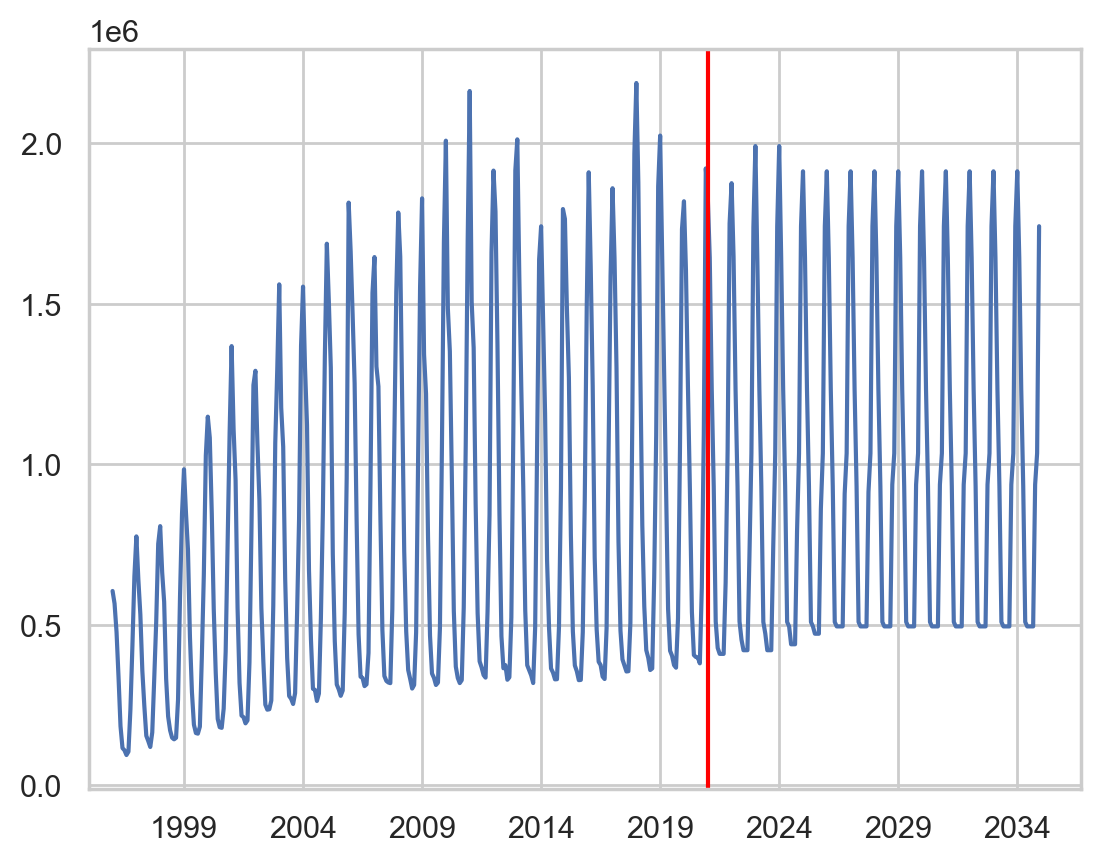

In [30]:
## 민수용 - 기존 값과 예측한 값 그래프로 확인 ##
civil_and_future['도시가스(톤)_민수용'].plot(xlim=[300,800])
plt.axvline('2021-01-01', color='red')
plt.show()

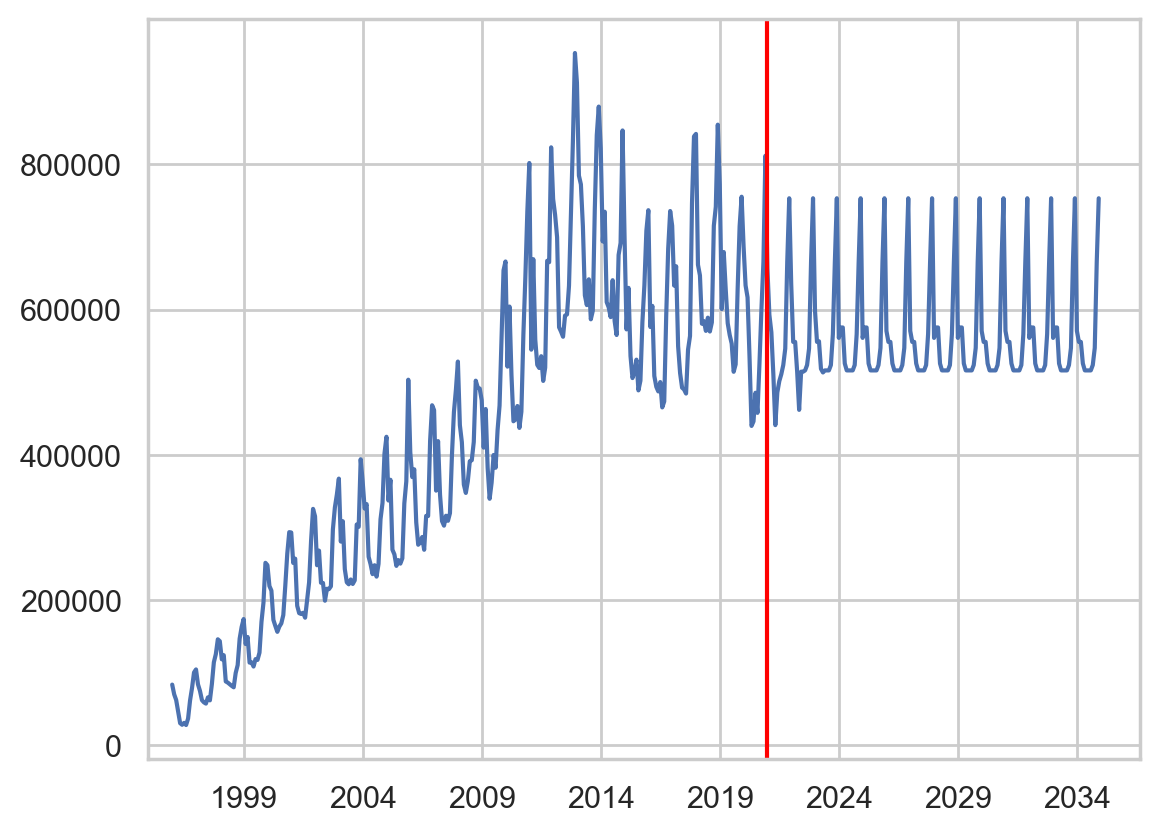

In [31]:
## 산업용 - 기존 값과 예측한 값 그래프로 확인 ##
ind_and_future['도시가스(톤)_산업용'].plot(xlim=[300,800])
plt.axvline('2021-01-01', color='red')
plt.show()

In [32]:
## 결과 제출파일 형식에 맞춰 바꿔주기 ##
fin_xgb = pd.DataFrame()
fin_xgb['YEAR']=civil_and_future['도시가스(톤)_민수용'].index.year
fin_xgb['MONTH']=civil_and_future['도시가스(톤)_민수용'].index.month
fin_xgb['CIVIL']=civil_and_future['도시가스(톤)_민수용'].values
fin_xgb['IND']=ind_and_future['도시가스(톤)_산업용'].values
fin_xgb = fin_xgb[300:]
fin_xgb.reset_index(drop=True, inplace=True)
fin_xgb

,YEAR,MONTH,CIVIL,IND
0,2021,1,1.833040e+06,656802.50000
1,2021,2,1.642870e+06,592907.43750
2,2021,3,1.233613e+06,568966.75000
3,2021,4,9.313156e+05,511027.43750
4,2021,5,5.105064e+05,441063.68750
...,...,...,...,...
163,2034,8,4.952107e+05,516405.18750
164,2034,9,4.952107e+05,523767.65625
165,2034,10,9.367454e+05,547381.62500
166,2034,11,1.034502e+06,665620.68750


# Neural Prophet Prediction

In [33]:
## 학슴된 모델 불러오기
# 난방도일 모델
with open(file='neuralprophet_temp_pred.pkl', mode='rb') as f:
    pi_temp = pickle.load(f)
    
# 민수용 수요 예측 모델
with open(file='neuralprophet_civil_pred.pkl', mode='rb') as f:
    pi_civil = pickle.load(f)
    
# KOSPI 모델
with open(file='neuralprophet_kospi_pred.pkl', mode='rb') as f:
    pi_kospi = pickle.load(f)
    
# 산업용 수요 예측 모델
with open(file='neuralprophet_ind_pred.pkl', mode='rb') as f:
    pi_ind = pickle.load(f)

### 민수용 수요 예측

In [34]:
## 냉난방도일 데이터 불러오기##
# 외부데이터파일('냉난방도일.csv') 사용 / 본 파일과 데이터파일이 같은 폴더에 위치한 후 실행가능

data = pd.read_csv('냉난방도일.csv')
data["ID"] = pd.date_range("1997-01-01", "2020-12-01", freq="MS")
df_temp = data[['ID', "난방도일 (도일)"]]
df_temp.rename(columns={'ID':'ds', '난방도일 (도일)':'y'}, inplace=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.319% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


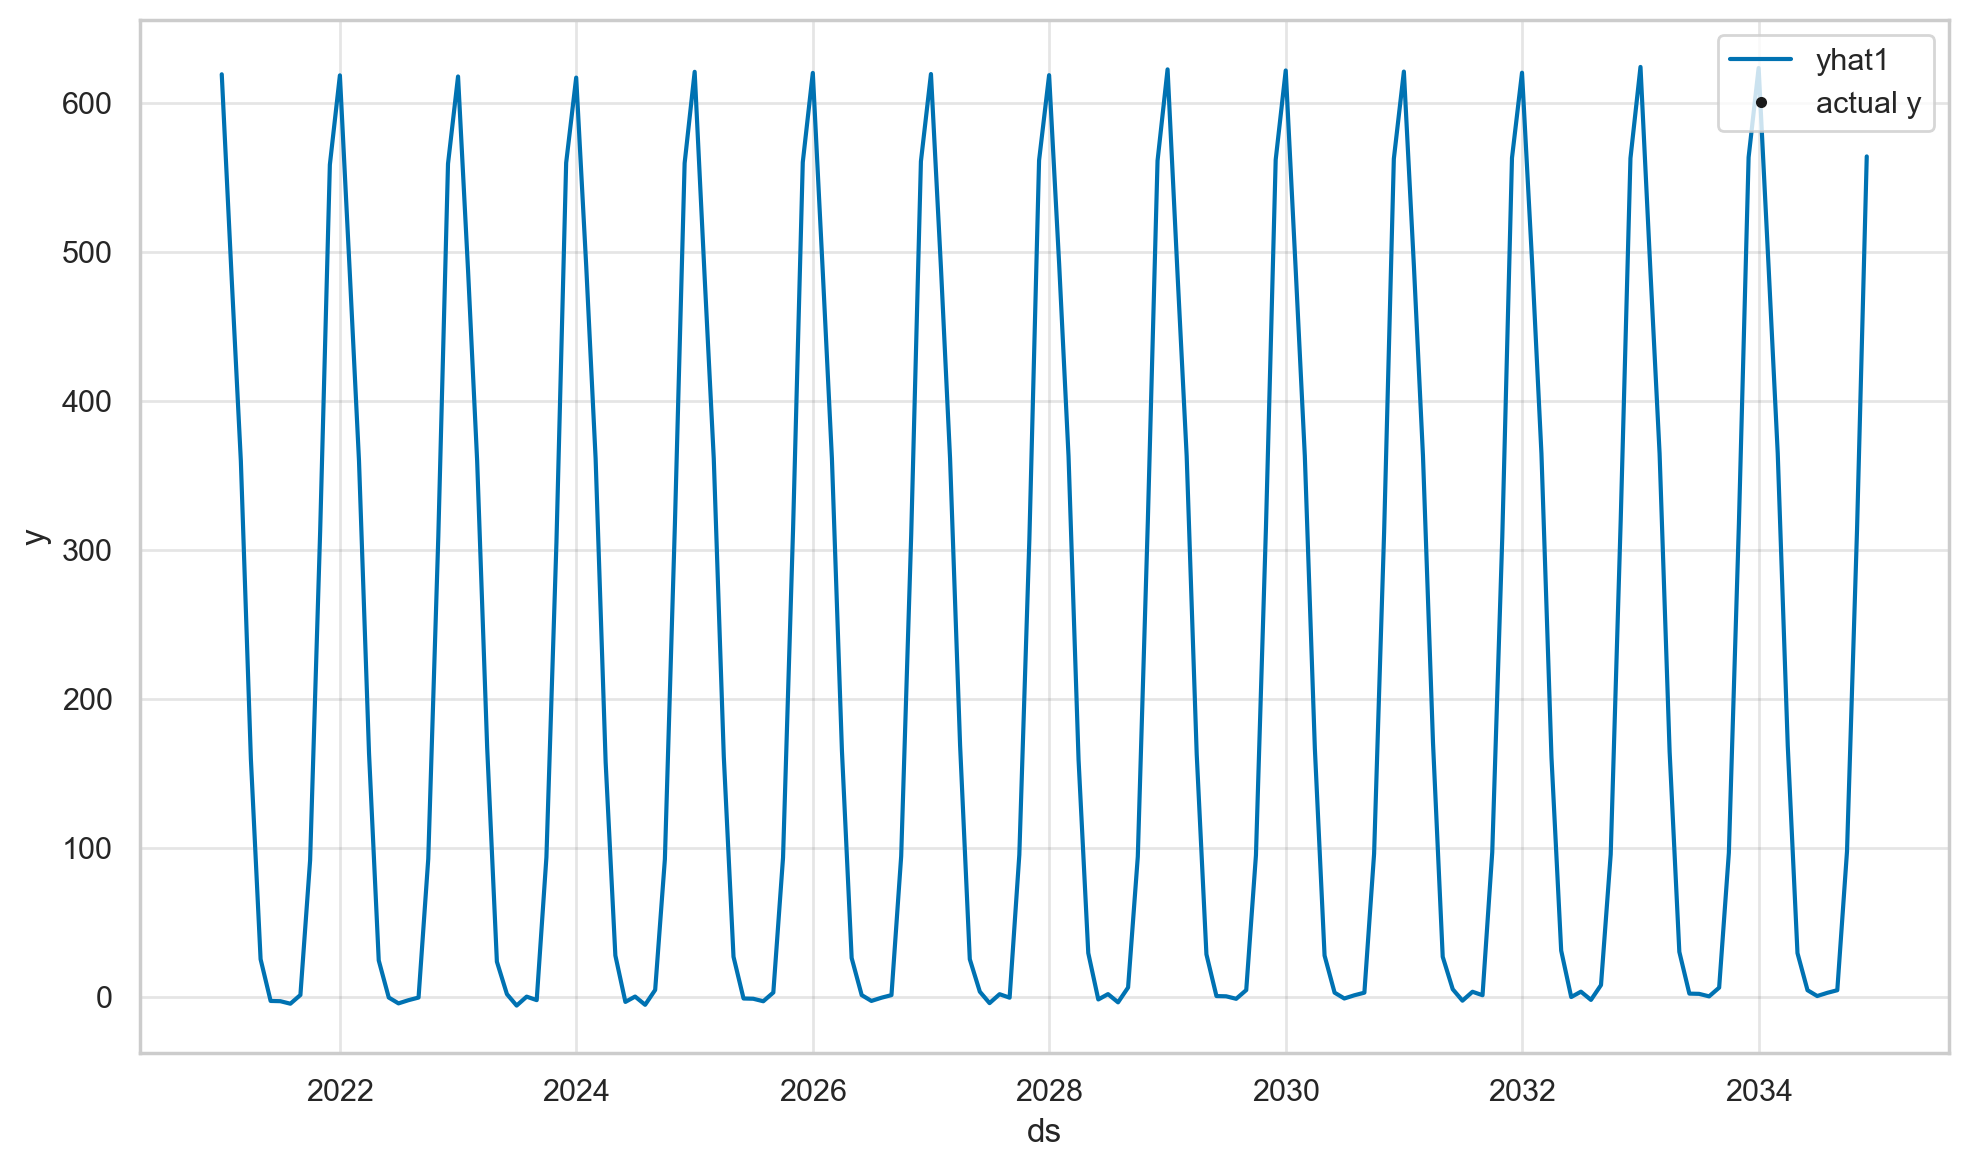

In [35]:
# 미래 14년치 예측을 위한 DataFrame 생성
future_temp = pi_temp.make_future_dataframe(df_temp, periods=12*14)

# 14년치 난방도일 예측값 확인
forecast2 = pi_temp.predict(future_temp)
forecasts_plot = pi_temp.plot(forecast2)

In [36]:
# 난방도일 예측치 저장
future_temp['y'] = forecast2['yhat1']

In [37]:
# 기존의 난방도일 Dataframe과 14년 예측치 병합
df_temp = pd.concat([df_temp,future_temp])
df_temp.rename(columns={'y':'temp'}, inplace=True)
df_temp

,ds,temp
0,1997-01-01,659.800000
1,1997-02-01,485.200000
2,1997-03-01,346.800000
3,1997-04-01,151.400000
4,1997-05-01,41.200000
...,...,...
163,2034-08-01,3.127134
164,2034-09-01,4.881328
165,2034-10-01,98.057060
166,2034-11-01,314.024841


In [38]:
## 민수용 데이터 불러오기 ##
# 제공된 데이터 파일(월별공급량및비중) 사용 / 본 파일과 데이터파일이 같은 폴더에 위치한 후 실행가능
data2 = pd.read_csv('월별공급량및비중.csv')
data2["ID"] = pd.date_range("1996-01-01", "2020-12-01", freq="MS")

# 외부변수로 활용한 난방도일 데이터가 1997년부터 존재하기에 1996년도 수요 데이터 삭제
idx_1996 = data2[data2['YEAR']<1997].index
data2 = data2.drop(idx_1996)

In [39]:
civil = data2[["ID", "도시가스(톤)_민수용"]]
civil

,ID,도시가스(톤)_민수용
12,1997-01-01,775522.0
13,1997-02-01,640683.0
14,1997-03-01,532435.0
15,1997-04-01,357484.0
16,1997-05-01,248334.0
...,...,...
295,2020-08-01,398661.0
296,2020-09-01,380235.0
297,2020-10-01,616682.0
298,2020-11-01,1093747.0


In [40]:
# 외부변수 temp(난방도일)를 생성하기 위해 df_temp와 병합
civil.rename(columns={'ID':'ds', '도시가스(톤)_민수용':'y'}, inplace=True)

civil = pd.merge(left=civil, right=df_temp, how="inner", on="ds")

In [41]:
# 미래 14년치 예측을 위한 DataFrame 생성
civil = civil.drop(["temp"], axis=1)
future_civil = pi_temp.make_future_dataframe(civil, periods=12*14)

# df_temp와의 병합을 통해 temp 변수 추가
future_civil = pd.merge(left=future_civil, right=df_temp, how="inner", on="ds")
future_civil.rename(columns={'temp_y':'temp'}, inplace=True)
future_civil

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.319% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,temp
0,2021-01-01,None,619.593811
1,2021-02-01,None,481.182770
2,2021-03-01,None,360.107422
3,2021-04-01,None,160.010117
4,2021-05-01,None,25.700172
...,...,...,...
163,2034-08-01,None,3.127134
164,2034-09-01,None,4.881328
165,2034-10-01,None,98.057060
166,2034-11-01,None,314.024841


In [42]:
# 민수용 수요 예측치 저장
forecast_civ = pi_civil.predict(future_civil)
civ_pred = forecast_civ['yhat1']
civ_pred

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


0      2.102982e+06
1      1.726016e+06
2      1.417599e+06
3      9.108610e+05
4      5.846422e+05
           ...     
163    5.136729e+05
164    5.013938e+05
165    7.741018e+05
166    1.431070e+06
167    2.401176e+06
Name: yhat1, Length: 168, dtype: float64

### 산업용 수요 예측

<AxesSubplot:>

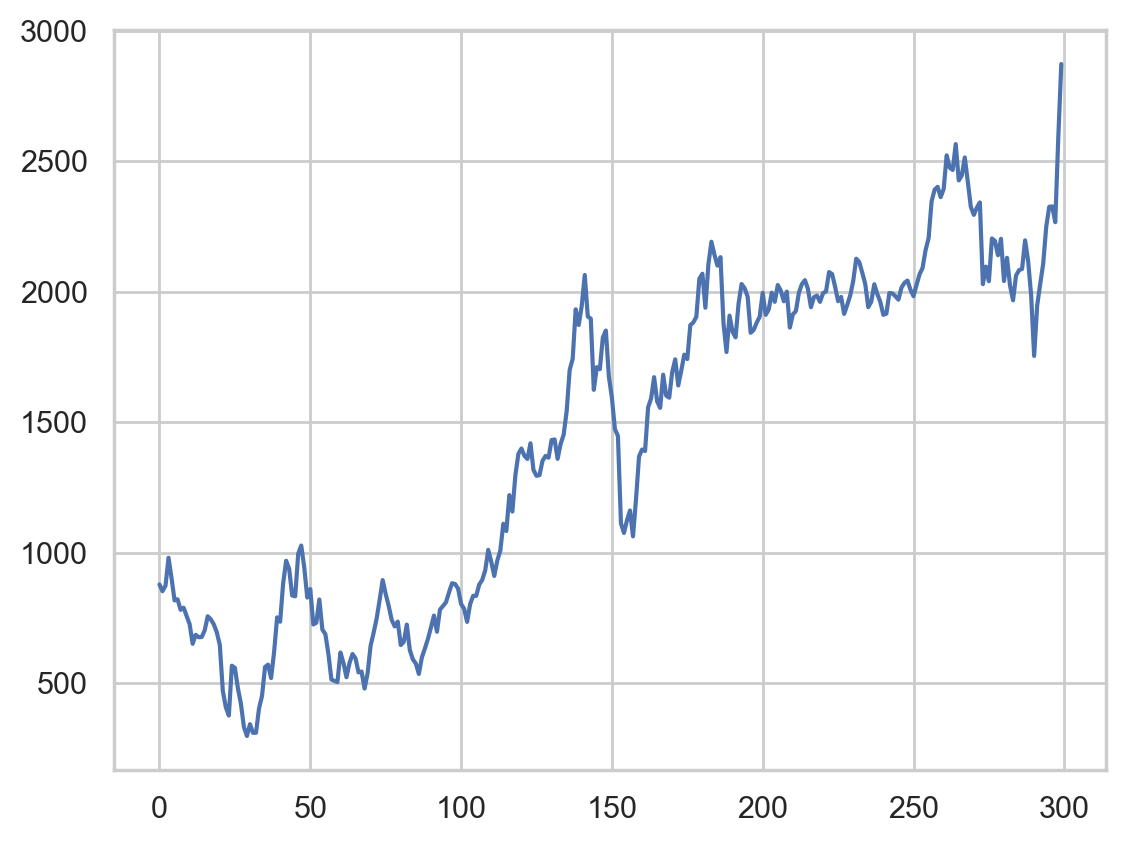

In [43]:
## KOSPI 데이터 불러오기##
# 외부데이터파일('코스피지수.csv') 사용 / 본 파일과 데이터파일이 같은 폴더에 위치한 후 실행가능
data3 = pd.read_csv('코스피지수.csv')
data3["ID"] = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
df_kospi = data3[['ID', "종가"]]
df_kospi['종가'].plot()

In [44]:
# 모델 사용을 위한 컬럼명 변경
df_kospi.rename(columns={'ID':'ds', '종가':'y'}, inplace=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


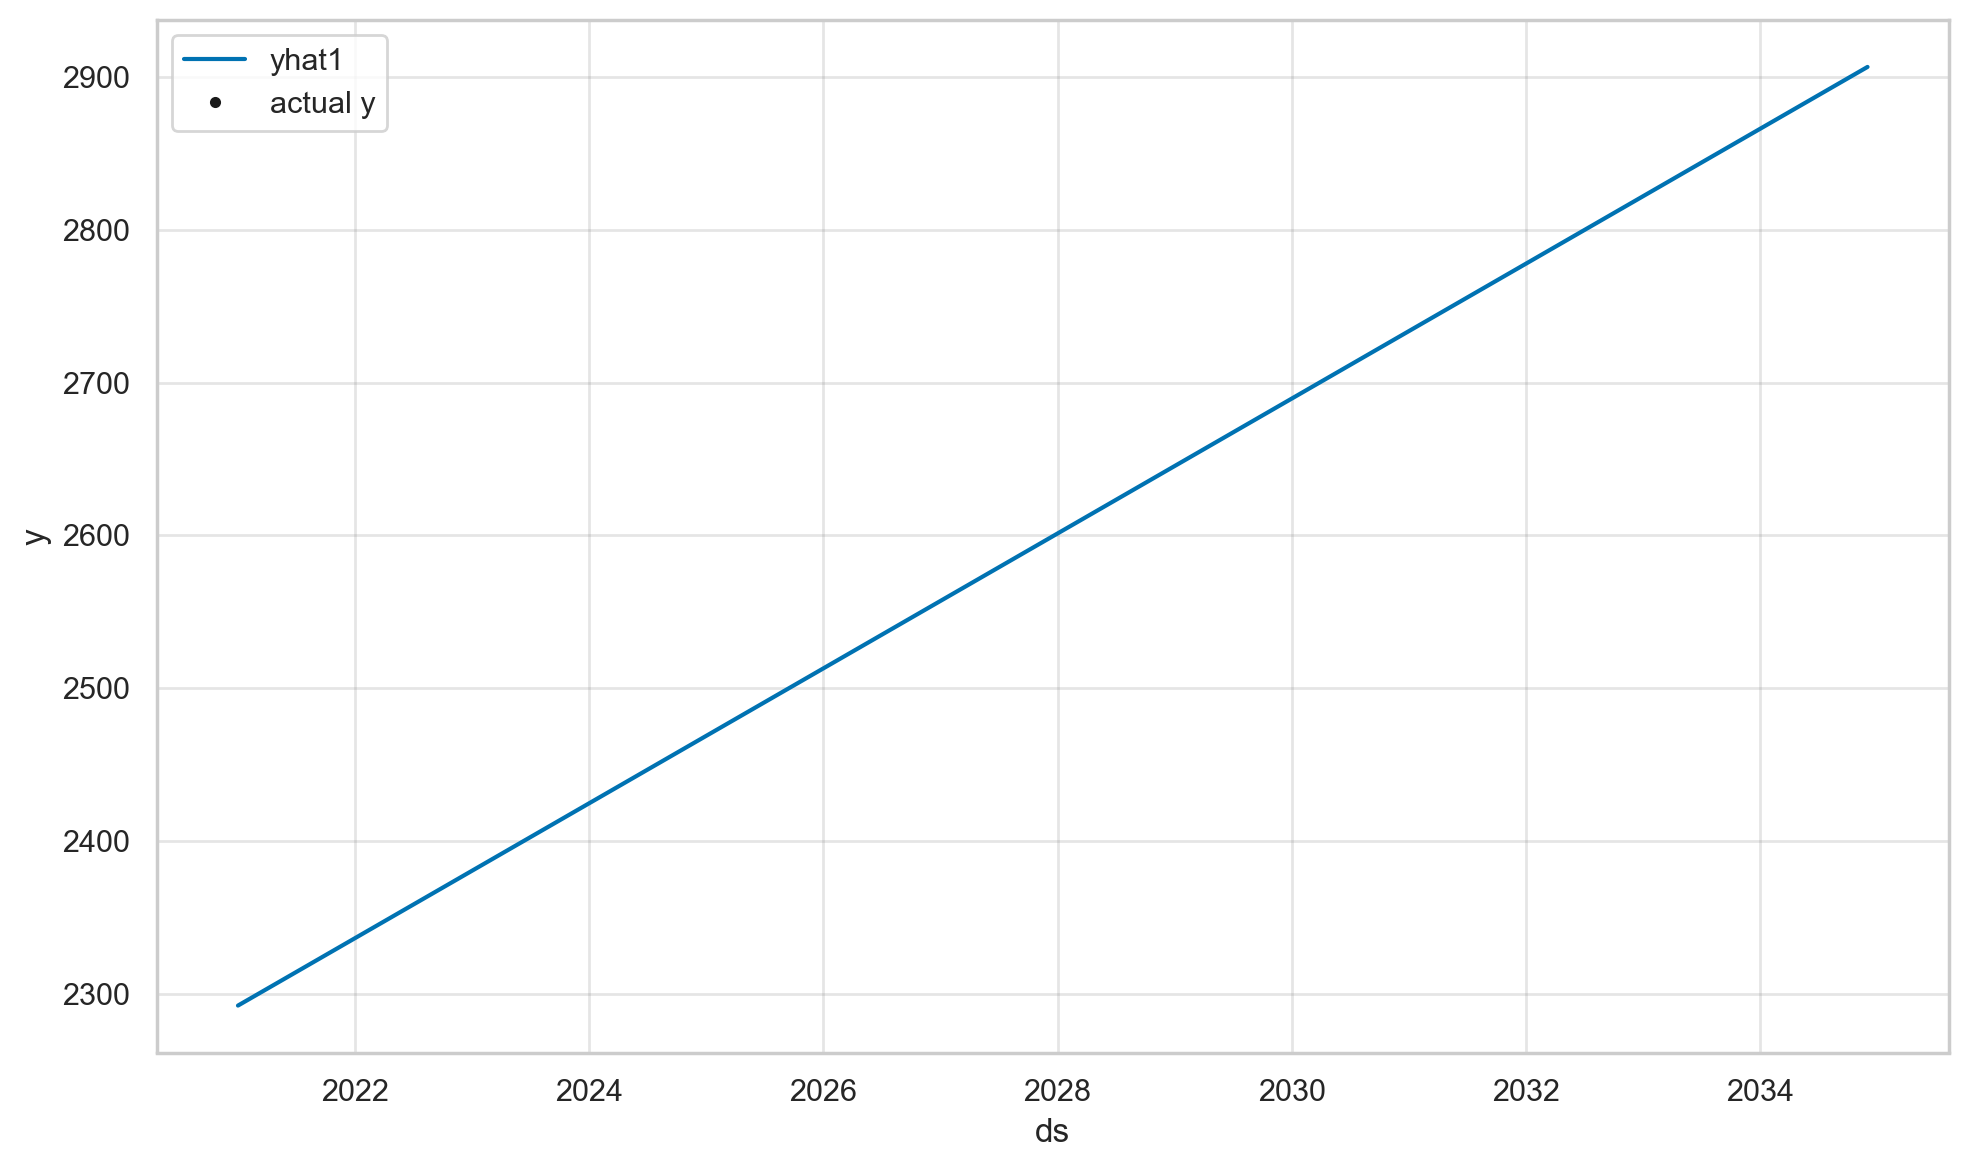

In [45]:
# 미래 14년치 예측을 위한 DataFrame 생성
future_kospi = pi_kospi.make_future_dataframe(df_kospi, periods=12*14)
# 14년치 KOSPI 예측값 확인
forecast2_kos = pi_kospi.predict(future_kospi)
forecasts_plot = pi_kospi.plot(forecast2_kos)

In [46]:
# KOSPI 예측치 저장
future_kospi['y'] = forecast2_kos['yhat1']

In [47]:
# 기존의 KOSPI Dataframe과 14년 예측치 병합
df_kospi = pd.concat([df_kospi,future_kospi])
df_kospi.rename(columns={'y':'kospi'}, inplace=True)
df_kospi

,ds,kospi
0,1996-01-01,878.820000
1,1996-02-01,852.830000
2,1996-03-01,874.160000
3,1996-04-01,980.900000
4,1996-05-01,903.090000
...,...,...
163,2034-08-01,2891.644043
164,2034-09-01,2895.389160
165,2034-10-01,2899.012695
166,2034-11-01,2902.756836


In [48]:
## 산업용 데이터 불러오기 ##
data2 = pd.read_csv('월별공급량및비중.csv')
data2["ID"] = pd.date_range("1996-01-01", "2020-12-01", freq="MS")

ind = data2[["ID", "도시가스(톤)_산업용"]]
ind

,ID,도시가스(톤)_산업용
0,1996-01-01,83809.0
1,1996-02-01,70427.0
2,1996-03-01,62652.0
3,1996-04-01,47050.0
4,1996-05-01,30709.0
...,...,...
295,2020-08-01,457970.0
296,2020-09-01,525619.0
297,2020-10-01,600890.0
298,2020-11-01,665901.0


In [49]:
# 외부변수 kospi(KOSPI)를 생성하기 위해 df_kospi와 병합
ind.rename(columns={'ID':'ds', '도시가스(톤)_산업용':'y'}, inplace=True)

ind = pd.merge(left=ind, right=df_kospi, how="inner", on="ds")
ind

,ds,y,kospi
0,1996-01-01,83809.0,878.82
1,1996-02-01,70427.0,852.83
2,1996-03-01,62652.0,874.16
3,1996-04-01,47050.0,980.90
4,1996-05-01,30709.0,903.09
...,...,...,...
295,2020-08-01,457970.0,2326.17
296,2020-09-01,525619.0,2327.89
297,2020-10-01,600890.0,2267.15
298,2020-11-01,665901.0,2591.34


In [50]:
# 미래 14년치 예측을 위한 DataFrame 생성
ind = ind.drop(["kospi"], axis=1)
future_ind = pi_kospi.make_future_dataframe(ind, periods=12*14)

# df_kospi와의 병합을 통해 ind 변수 추가
future_ind = pd.merge(left=future_ind, right=df_kospi, how="inner", on="ds")
future_ind.rename(columns={'kospi_y':'kospi'}, inplace=True)
future_ind

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,kospi
0,2021-01-01,None,2292.525879
1,2021-02-01,None,2296.270508
2,2021-03-01,None,2299.652344
3,2021-04-01,None,2303.396973
4,2021-05-01,None,2307.020508
...,...,...,...
163,2034-08-01,None,2891.644043
164,2034-09-01,None,2895.389160
165,2034-10-01,None,2899.012695
166,2034-11-01,None,2902.756836


In [51]:
# 산업용 수요 예측치 저장
forecast_ind = pi_ind.predict(future_ind)
ind_pred = forecast_ind['yhat1']
ind_pred

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.071% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


0      703227.37500
1      604784.50000
2      627042.93750
3      544834.87500
4      516446.90625
           ...     
163    398124.62500
164    415867.62500
165    493557.59375
166    547575.75000
167    620236.12500
Name: yhat1, Length: 168, dtype: float64

In [52]:
## 결과 제출파일 형식에 맞춰 바꿔주기 ##
fin_nrp = pd.DataFrame()
fin_nrp['YEAR']=forecast_civ['ds'].dt.year
fin_nrp['MONTH']=forecast_civ['ds'].dt.month
fin_nrp['CIVIL']=forecast_civ['yhat1']
fin_nrp['IND']=forecast_ind['yhat1']
fin_nrp

,YEAR,MONTH,CIVIL,IND
0,2021,1,2.102982e+06,703227.37500
1,2021,2,1.726016e+06,604784.50000
2,2021,3,1.417599e+06,627042.93750
3,2021,4,9.108610e+05,544834.87500
4,2021,5,5.846422e+05,516446.90625
...,...,...,...,...
163,2034,8,5.136729e+05,398124.62500
164,2034,9,5.013938e+05,415867.62500
165,2034,10,7.741018e+05,493557.59375
166,2034,11,1.431070e+06,547575.75000


In [53]:
## 모델 별 일정 비율로 합친 후 저장 ##
final = pd.DataFrame()
final['YEAR'] = fin_lstm['YEAR']
final['MONTH'] = fin_lstm['MONTH']
final['CIVIL'] = fin_lstm['CIVIL']*0.4 + fin_xgb['CIVIL']*0.4 + fin_nrp['CIVIL']*0.2
final['IND'] = fin_lstm['IND']*0.5 + fin_xgb['IND']*0.2 + fin_nrp['IND']*0.3
final.to_csv("result.csv", mode='w', index=False)

In [54]:
## 전체 데이터 그래프를 보기위한 선작업(index 조정) ##
civil = data2["도시가스(톤)_민수용"]
civil.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = data2["도시가스(톤)_산업용"]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
final.index = pd.date_range("2021-01-01", "2034-12-01", freq="MS")

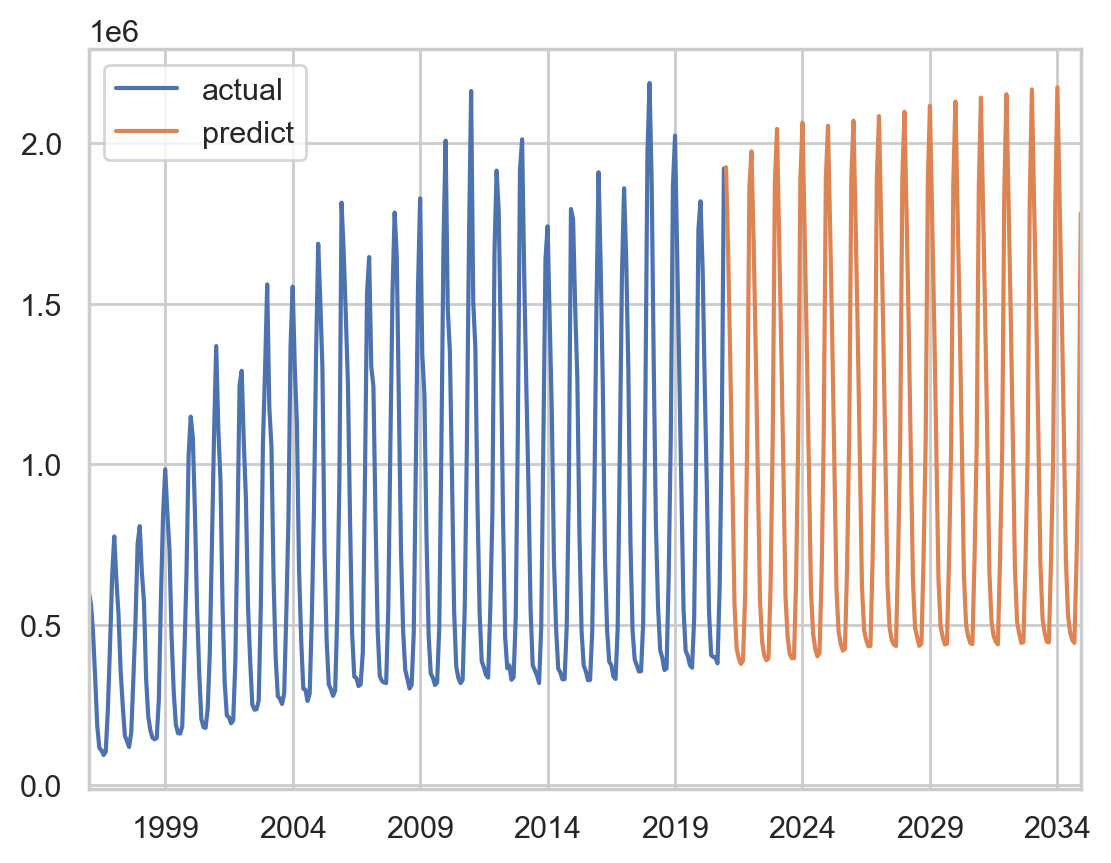

In [55]:
## 민수용 그래프 ##
civil.plot()
final['CIVIL'].plot()
plt.legend(['actual','predict'])

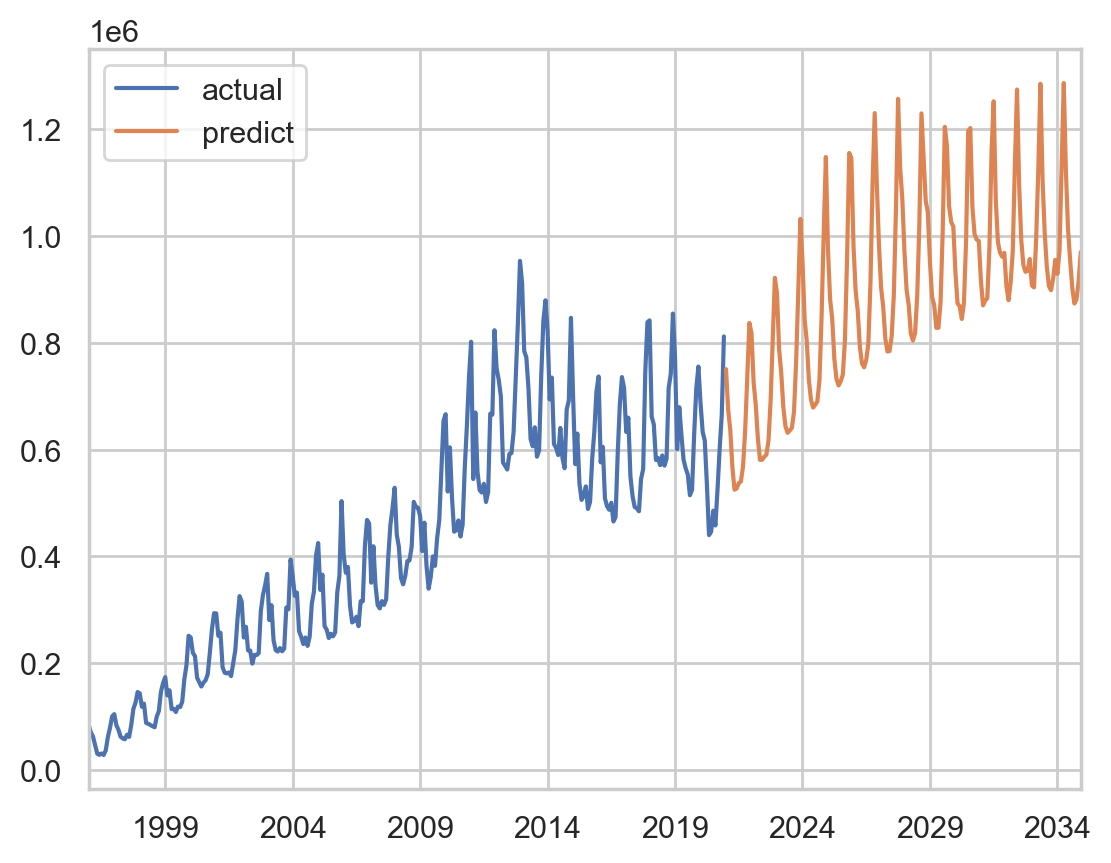

In [56]:
## 산업용 그래프 ##
ind.plot()
final['IND'].plot()
plt.legend(['actual','predict'])